<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Pollardstown__Rf__HIre_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd

In [2]:
shapefile_path = "/content/Pollardstown_clappied.shp"
gdf = gpd.read_file(shapefile_path)

freq_table = gdf['PRIMARY_FO'].value_counts()

# Print the frequency table
print(freq_table)

PRIMARY_FO
PF1        12
GS4         6
FS1         6
WN6/FS1     2
WN6         2
FS1/PF1     2
GA1         1
GS4/FS2     1
FS1/FS2     1
WS1/WL2     1
GS4/WS1     1
GS4/FS1     1
WL2         1
Name: count, dtype: int64


In [3]:
# 1. Select only the name and ID columns
# Assuming 'PRIMARY_FO' is the name and 'class_id' is the number
mapping_table = gdf[['PRIMARY_FO', 'Id']].drop_duplicates()

# 2. Sort by ID to make it easy to read
mapping_table = mapping_table.sort_values(by='Id')

# 3. Print the table
print("Pollardstown Habitat ID Mapping:")
print("-" * 40)
print(mapping_table.to_string(index=False))

# Optional: If you want to see how many polygons exist for each class
print("\nPolygon Count per Habitat Type:")
print(gdf['PRIMARY_FO'].value_counts())

Pollardstown Habitat ID Mapping:
----------------------------------------
PRIMARY_FO  Id
       PF1   2
       FS1   9
   FS1/FS2  10
   FS1/PF1  11
       GA1  12
       GS4  13
   GS4/FS1  14
   GS4/FS2  15
   GS4/WS1  16
       WL2  17
       WN6  18
   WN6/FS1  19
   WS1/WL2  20

Polygon Count per Habitat Type:
PRIMARY_FO
PF1        12
GS4         6
FS1         6
WN6/FS1     2
WN6         2
FS1/PF1     2
GA1         1
GS4/FS2     1
FS1/FS2     1
WS1/WL2     1
GS4/WS1     1
GS4/FS1     1
WL2         1
Name: count, dtype: int64


3 Classes?  
Super-Class;	Fossitt Codes Included;	IDs	Description
1. Wetland & Fen;	PF1, FS1, FS1/FS2, FS1/PF1	2, 9, 10, 11;	The core "Wet" areas. High water table, specialized sedges/mosses.  
2. Grassland;	GA1, GS4, GS4/FS1	12, 13, 14;	Open "Green" areas. Dominated by grasses; higher NDVI, smoother texture.  
3. Woody & Mosaic;	GS4/FS2, GS4/WS1, WL2, WN6, WN6/FS1, WS1/WL2	15, 16, 17, 18, 19, 20;	"Structural" areas. Scrub, trees, and complex scrub-grassland mixes.

In [4]:
!pip install rasterio

In [1]:
import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask
from rasterio import features
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from scipy.ndimage import uniform_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
# Load RGB image
rgb = rasterio.open("/content/pollardstown_ortho.tif")

# Load ndvi image
ndvi = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")

# Load habitat map (vector)
habitat = gpd.read_file("/content/Pollardstown_clappied.shp")

In [3]:
# Reproject habitat to match RGB CRS
habitat = habitat.to_crs(rgb.crs)


In [8]:
out_image, out_transform = mask(rgb, habitat.geometry, crop=True)

In [9]:
out_meta = rgb.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [10]:
with rasterio.open("clipped_rgb.tif", "w", **out_meta) as dest:
    dest.write(out_image)

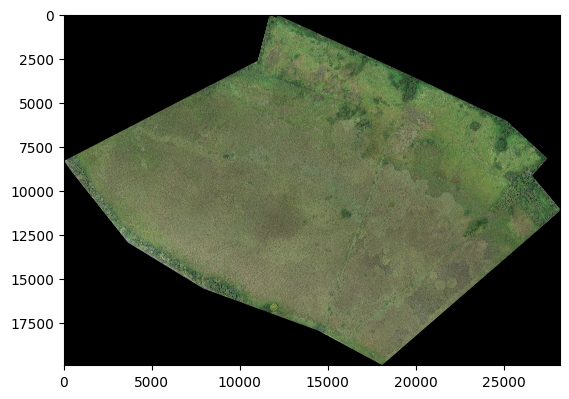

In [11]:
import matplotlib.pyplot as plt

with rasterio.open("clipped_rgb.tif") as src:
    plt.imshow(src.read().transpose((1, 2, 0)))
    plt.show()

In [4]:
target_h, target_w = ndvi.height, ndvi.width
target_transform = ndvi.transform

In [5]:
print("Resampling RGB and cleaning NDVI...")
rgb_data = rgb.read(out_shape=(rgb.count, target_h, target_w), resampling=Resampling.bilinear)
ndvi_data = ndvi.read(1).astype('float32')
ndvi_data = np.clip(np.nan_to_num(ndvi_data, nan=0.0), -1.0, 1.0)

print("Calculating Texture (Structural Roughness)...")
c1 = uniform_filter(ndvi_data, size=5)
c2 = uniform_filter(np.square(ndvi_data), size=5)
texture_data = np.sqrt(np.abs(c2 - np.square(c1)))

print("Stacking bands into 5-feature image...")
img_stack = np.vstack((rgb_data, ndvi_data[np.newaxis, :, :], texture_data[np.newaxis, :, :]))
n_bands = img_stack.shape[0]

# Cleanup RAM
del rgb_data, texture_data, c1, c2
gc.collect()

Resampling RGB and cleaning NDVI...
Calculating Texture (Structural Roughness)...
Stacking bands into 5-feature image...


0

In [10]:
print("Rasterizing shapefile...")
habitat_vec = habitat.to_crs(ndvi.crs)
shapes = ((geom, value) for geom, value in zip(habitat_vec.geometry, habitat_vec['Id']))
labeled_pixels = features.rasterize(shapes, out_shape=(target_h, target_w), transform=target_transform, fill=0)

X_all_flat = img_stack.reshape(n_bands, -1).T
y_all_flat = labeled_pixels.ravel()

# Balanced Sampling
print("Extracting balanced samples...")
target_samples = 3000
X_list, y_list = [], []
unique_ids = np.unique(y_all_flat[y_all_flat > 0])

for class_id in unique_ids:
    idx = np.where(y_all_flat == class_id)[0]
    n = min(len(idx), target_samples)
    chosen = np.random.choice(idx, n, replace=False)
    X_list.append(X_all_flat[chosen])
    y_list.append(y_all_flat[chosen])

X_final = np.vstack(X_list)
y_final = np.concatenate(y_list)

Rasterizing shapefile...
Extracting balanced samples...


In [11]:
three_class_map = {
    2: 1, 9: 1, 10: 1, 11: 1,           # Fen
    12: 2, 13: 2, 14: 2,                # Grassland
    15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3 # Woody/Mosaic
}
y_final_3 = np.array([three_class_map[val] for val in y_final])

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final_3, test_size=0.3, stratify=y_final_3, random_state=42)

In [8]:
print("Training 3-Class Random Forest...")
rf = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

Training 3-Class Random Forest...


RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

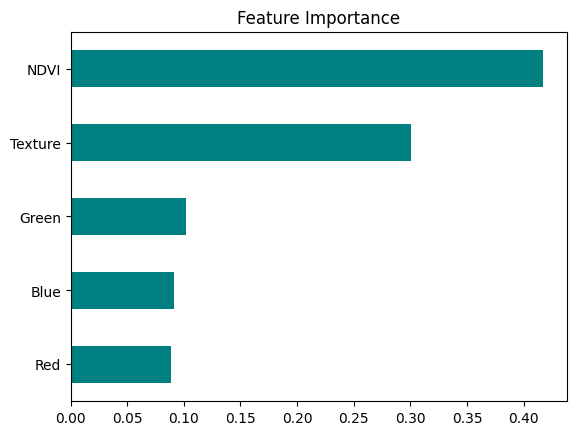

In [9]:
importances = pd.Series(rf.feature_importances_, index=['Red', 'Green', 'Blue', 'NDVI', 'Texture'])
importances.sort_values().plot(kind='barh', color='teal', title="Feature Importance")
plt.show()


In [ ]:
# Report
target_names = ['Wetland/Fen', 'Grassland', 'Woody/Mosaic']
print(classification_report(y_test, rf.predict(X_test), target_names=target_names))

In [10]:
print("Training 3-Class Random Forest...")
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

Training 3-Class Random Forest...


RandomForestClassifier(max_depth=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [11]:
# Report
target_names = ['Wetland/Fen', 'Grassland', 'Woody/Mosaic']
print(classification_report(y_test, rf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

 Wetland/Fen       0.65      0.68      0.67      2723
   Grassland       0.30      0.12      0.17      1801
Woody/Mosaic       0.71      0.85      0.77      4712

    accuracy                           0.66      9236
   macro avg       0.55      0.55      0.54      9236
weighted avg       0.61      0.66      0.62      9236



In [8]:
print("Training 3-Class Random Forest...")
rf = RandomForestClassifier(n_estimators=5000, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

Training 3-Class Random Forest...


RandomForestClassifier(max_depth=20, n_estimators=5000, n_jobs=-1,
                       random_state=42)

In [9]:
# Report
target_names = ['Wetland/Fen', 'Grassland', 'Woody/Mosaic']
print(classification_report(y_test, rf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

 Wetland/Fen       0.64      0.65      0.65       923
   Grassland       0.33      0.16      0.21       601
Woody/Mosaic       0.72      0.85      0.78      1712

    accuracy                           0.66      3236
   macro avg       0.57      0.55      0.55      3236
weighted avg       0.63      0.66      0.64      3236

